## Dog Vs Cat: A CNN based Dog/Cat Classifer 

# enviroment setup

In [1]:
import numpy as np
import os
import glob
import cv2
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 5.0)

TRAIN_DATA_PATH_LIST = ["./train"]
TEST_DATA_PATH_LIST = ["./test"]

# load and processing data

In [23]:
def load_data(DATA_PATH):
    labels = ["dog", "cat"]
    labeled_data = {}
    for dir in DATA_PATH: 
        print("processing data from: " + dir)
        for key in labels:           
            labeled_data[key] = [file for file in glob.glob(os.path.join(dir, key + '*.jpg'))]
            print("total " + str(len(labeled_data[key])) + " " + key + " images found.")
        
    return labeled_data


def raw_data_analysis(data):
    image_size_counter = {}    
    dimension_shape = ["height", "width"]
    for key in data.keys():
        print("processing: " + key)
        image_size_counter[key] = {}
        image_size_counter[key][dimension_shape[0]] = Counter()
        image_size_counter[key][dimension_shape[1]] = Counter()
        for img_path in data[key]:
            img = cv2.imread(img_path)            
            image_size_counter[key][dimension_shape[0]][img.shape[0]] += 1
            image_size_counter[key][dimension_shape[0]][img.shape[1]] += 1
    
        for dim in dimension_shape:
            print("most common " + key + " image " + dim + ": " , image_size_counter[key][dim].most_common(10))    
        #print("most common " + key + " image width: ", image_size_counter[key]["width"].most_common(10))
        #print("most common " + key + " image height: ", image_size_counter[key]["height"].most_common(10))
    
    return image_size_counter
        
    

data = load_data(TRAIN_DATA_PATH_LIST)


temp_counter_dict = raw_data_analysis(data)
    



processing data from: ./train
total 12500 dog images found.
total 12500 cat images found.
processing: dog
most common dog image width:  [(374, 1400), (375, 1345), (500, 1040), (499, 993), (332, 153), (333, 152), (399, 150), (299, 130), (240, 123), (300, 122)]
most common dog image height:  [(500, 2486), (499, 2398), (350, 197), (400, 194), (399, 175), (375, 174), (299, 162), (319, 160), (320, 155), (300, 146)]
processing: cat
most common cat image width:  [(374, 1684), (375, 1614), (499, 846), (500, 804), (333, 166), (332, 155), (239, 149), (240, 130), (299, 108), (359, 89)]
most common cat image height:  [(499, 2914), (500, 2859), (349, 188), (300, 181), (350, 175), (319, 165), (320, 164), (299, 149), (399, 149), (400, 142)]


dog height
max value 2486 min value 1
max key 1050 min key 42
dog width
max value 1400 min value 1
max key 702 min key 33


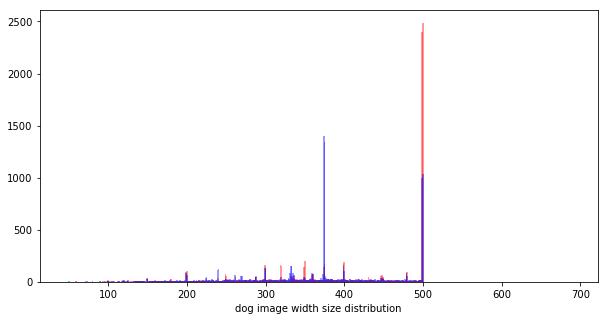

cat height
max value 2914 min value 1
max key 1023 min key 50
cat width
max value 1684 min value 1
max key 768 min key 32


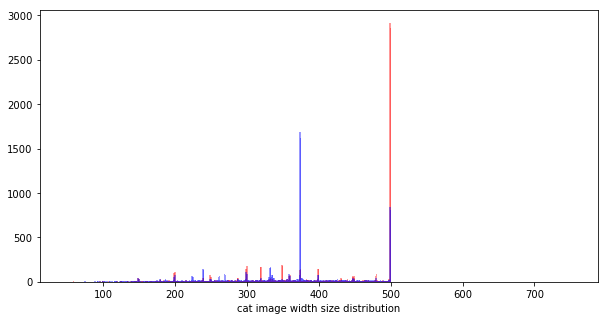

In [35]:
COLOR = ["red", "blue"]
color_index = 0

for key in temp_counter_dict.keys():
    fig, ax = plt.subplots()
    size_types = temp_counter_dict[key].keys()
    for dim in size_types:
        print(key, dim)
        data_keys = sorted(temp_counter_dict[key][dim].keys())       
        data_values = [temp_counter_dict[key][dim][i] for i in data_keys]
        print("max value", max(data_values),"min value", min(data_values))
        print("max key", max(data_keys),"min key", min(data_keys))
        
        plt.bar(data_keys, data_values, width = 2, align='center', color=COLOR[color_index % 2], alpha=0.4)
        color_index += 1 
        plt.xlim(min(data_keys) - 20, max(data_keys) + 20)
        plt.xlabel(key + ' image ' + dim + " size distribution")
    
    plt.show()   
        
    '''
    y_pos = np.arange(len(size_types))
    counts = [int(temp_counter_dict[key][x]) for x in temp_counter_dict[key]]
    print(len(y_pos), len(counts))
    ax.barh(y_pos, counts, align='center', color = "blue")
    ax.set_yticks(y_pos)
    ax.set_yticklabels(size_types)
    ax.set_title(key + " image size distribution")
    '''
    
 
    